In [9]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import datetime as dt
from enerpi.base import timeit
from prettyprinting import *
import re


INIT_LOG_MARK = "Init ENERPI logging & broadcasting..."


@timeit('extract_log_file')
def extract_log_file(log_file, extract_temps=True, verbose=True):
    rg_log_msg = re.compile('(?P<tipo>INFO|WARNING|DEBUG|ERROR) \[(?P<func>.+?)\] '
                            '- (?P<ts>\d{1,2}/\d\d/\d\d\d\d \d\d:\d\d:\d\d): (?P<msg>.*?)\n', re.DOTALL)
    with open(log_file, 'r') as log_f:
        df_log = pd.DataFrame(rg_log_msg.findall(log_f.read()),
                              columns=['tipo', 'func', 'ts', 'msg'])
    df_log.drop('func', axis=1, inplace=True)
    df_log['tipo'] = df_log['tipo'].astype('category')
    df_log['ts'] = df_log['ts'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
    df_log.loc[df_log.msg.str.startswith('Tªs --> '), 'temp'] = True
    df_log.loc[df_log.msg.str.startswith('SENDED: '), 'debug_send'] = True
    b_warn = df_log.tipo == 'WARNING'
    df_log.loc[b_warn, 'no_red'] = df_log[b_warn].msg.str.startswith('OSError: [Errno 101] La red es inaccesible')
    df_log['exec'] = df_log['msg'].str.contains(INIT_LOG_MARK).cumsum().astype(int)
    df_log = df_log.set_index('ts')
    if extract_temps:
        rg_temps = 'Tªs --> (?P<CPU>\d{1,2}\.\d) / (?P<GPU>\d{1,2}\.\d) ºC'
        df_log = df_log.join(df_log[df_log['temp'].notnull()].msg.str.extract(rg_temps, expand=True).astype(float))
    if verbose:
        clasific = df_log.groupby(['exec', 'tipo']).count().dropna(how='all').astype(int)
        print_ok(clasific)
        conteo_tipos = df_log.groupby('tipo').count()
        if 'ERROR' in conteo_tipos.index:
            print_err(df_log[df_log.tipo == 'ERROR'].dropna(how='all', axis=1))
        if 'INFO' in conteo_tipos.index:
            print_info(df_log[df_log.tipo == 'INFO'].dropna(how='all', axis=1))
    return df_log


os.chdir('/Users/uge/Dropbox/PYTHON/PYPROJECTS/enerpi/enerpi/DATA/')
log_file = 'enerpi.log'
df_log = extract_log_file(log_file, extract_temps=True, verbose=True)
df_log.head()

                msg   temp  debug_send  no_red    CPU    GPU
exec tipo                                                   
0    INFO         1      0           0       0      0      0
     WARNING      1      0           0       1      0      0
1    INFO         2      0           0       0      0      0
     WARNING      1      0           0       1      0      0
2    INFO         2      0           0       0      0      0
     WARNING      1      0           0       1      0      0
3    DEBUG      125      0           0       0      0      0
     INFO         2      0           0       0      0      0
     WARNING    211      0           0     211      0      0
4    DEBUG    11400  11277           0       0  11367  11367
     INFO         1      0           0       0      0      0
     WARNING    722      0           0     722    246    246
                     tipo                                    msg  exec
ts                                                                    
2016

,tipo,msg,temp,debug_send,no_red,exec,CPU,GPU
ts,,,,,,,,
2016-08-10 21:22:31,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,NaN,NaN,0,NaN,NaN
2016-08-10 21:22:31,WARNING,"HDF Store not found at ""/home/pi/PYTHON/enerpi...",NaN,NaN,False,0,NaN,NaN
2016-08-10 21:22:31,INFO,Init ENERPI logging & broadcasting...,NaN,NaN,NaN,1,NaN,NaN
2016-08-10 21:26:26,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,NaN,NaN,1,NaN,NaN
2016-08-10 21:26:26,WARNING,"HDF Store not found at ""/home/pi/PYTHON/enerpi...",NaN,NaN,False,1,NaN,NaN


In [11]:
last = df_log[df_log['exec'] == 4]
last.tail(10)

,tipo,msg,temp,debug_send,no_red,exec,CPU,GPU
ts,,,,,,,,
2016-08-12 10:15:18,DEBUG,Tªs --> 74.1 / 74.1 ºC,True,NaN,NaN,4,74.1,74.1
2016-08-12 10:15:19,WARNING,OSError: [Errno 101] La red es inaccesible; C_...,NaN,NaN,True,4,NaN,NaN
2016-08-12 10:15:20,WARNING,OSError: [Errno 101] La red es inaccesible; C_...,NaN,NaN,True,4,NaN,NaN
2016-08-12 10:15:21,DEBUG,Tªs --> 71.4 / 72.0 ºC,True,NaN,NaN,4,71.4,72.0
2016-08-12 10:15:24,DEBUG,Tªs --> 69.8 / 69.8 ºC,True,NaN,NaN,4,69.8,69.8
2016-08-12 10:15:27,DEBUG,Tªs --> 68.8 / 68.8 ºC,True,NaN,NaN,4,68.8,68.8
2016-08-12 10:15:30,DEBUG,Tªs --> 69.3 / 68.8 ºC,True,NaN,NaN,4,69.3,68.8
2016-08-12 10:15:33,DEBUG,Tªs --> 68.8 / 68.8 ºC,True,NaN,NaN,4,68.8,68.8
2016-08-12 10:15:36,DEBUG,Tªs --> 68.8 / 68.8 ºC,True,NaN,NaN,4,68.8,68.8


In [14]:
last[~last.no_red.fillna(False) & ~last.temp.fillna(False)]

,tipo,msg,temp,debug_send,no_red,exec,CPU,GPU
ts,,,,,,,,
2016-08-12 00:47:21,INFO,Init ENERPI logging & broadcasting...,NaN,NaN,NaN,4,NaN,NaN
2016-08-12 00:48:23,DEBUG,"Size Store: 2e+01 KB, 60 rows",NaN,NaN,NaN,4,NaN,NaN
2016-08-12 00:49:23,DEBUG,"Size Store: 2e+01 KB, 120 rows",NaN,NaN,NaN,4,NaN,NaN
2016-08-12 00:50:23,DEBUG,"Size Store: 3e+01 KB, 180 rows",NaN,NaN,NaN,4,65.0,65.0
2016-08-12 00:51:24,DEBUG,"Size Store: 3e+01 KB, 240 rows",NaN,NaN,NaN,4,NaN,NaN
2016-08-12 00:52:24,DEBUG,"Size Store: 4e+01 KB, 300 rows",NaN,NaN,NaN,4,66.1,65.5
2016-08-12 00:53:25,DEBUG,"Size Store: 5e+01 KB, 360 rows",NaN,NaN,NaN,4,NaN,NaN
2016-08-12 00:54:25,DEBUG,"Size Store: 5e+01 KB, 420 rows",NaN,NaN,NaN,4,65.5,65.5
2016-08-12 00:55:26,DEBUG,"Size Store: 6e+01 KB, 480 rows",NaN,NaN,NaN,4,NaN,NaN


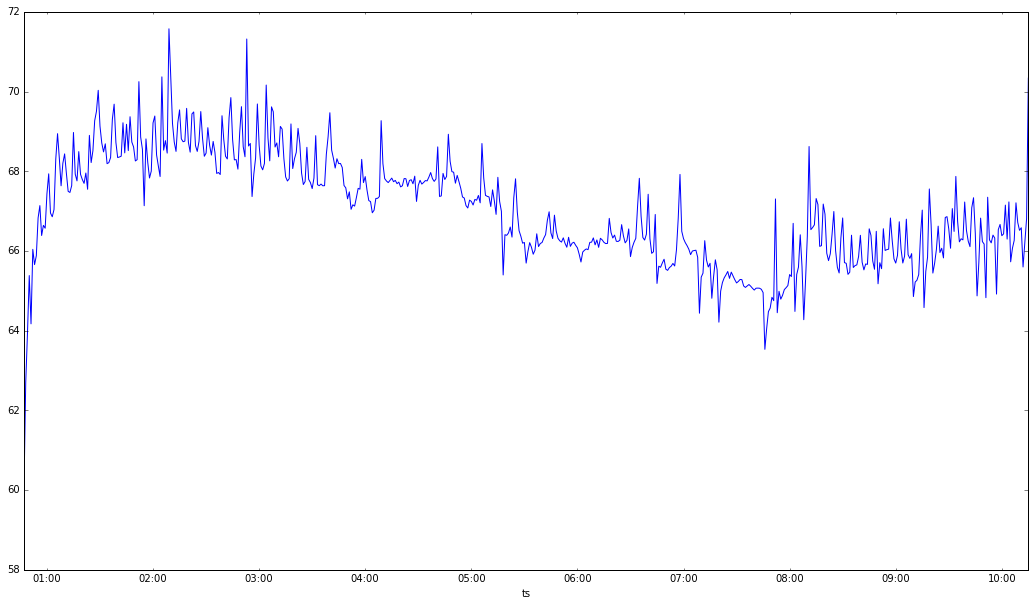

In [20]:
last[last.temp.fillna(False)][['CPU', 'GPU']].mean(axis=1).resample('1min').mean().plot(figsize=(18, 10))

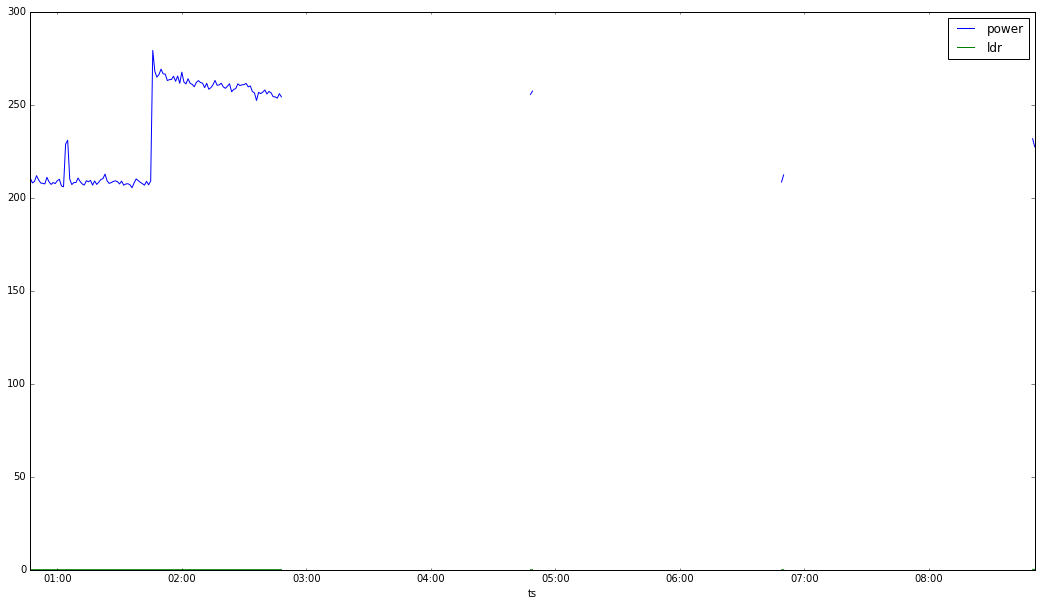

In [21]:
data = pd.read_hdf('temp_data.h5', 'rms')
data.resample('1min').mean()[['power', 'ldr']].plot(figsize=(18, 10))

In [68]:
from enerpi.api import extract_log_file

log = extract_log_file('enerpi.log')
data = pd.read_hdf('TODAY.h5', 'rms')
log = log[log['exec'] == 2].dropna(how='all', axis=1)
print(log.head())
log.tail()

             msg  temp  debug_send  no_red  CPU  GPU
exec tipo                                           
0    INFO      1     0           0       0    0    0
1    DEBUG    13     0           0       0    0    0
     INFO      2     0           0       0    0    0
2    DEBUG  1411     0           0       0    0    0
     INFO      1     0           0       0    0    0
                     tipo                                    msg  exec
ts                                                                    
2016-08-12 10:47:29  INFO       ︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡     0
2016-08-12 10:47:29  INFO  Init ENERPI logging & broadcasting...     1
2016-08-12 10:53:34  INFO       ︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡     1
2016-08-12 10:53:34  INFO  Init ENERPI logging & broadcasting...     2
extract_log_file TOOK: 0.054 s
                      tipo                                                msg  exec
ts                                                                                 
2016

,tipo,msg,exec
ts,,,
2016-08-12 20:21:40,DEBUG,"Size Store: 1052.9 KB, 34140 rows",2
2016-08-12 20:22:10,DEBUG,"Size Store: 1088.5 KB, 34170 rows",2
2016-08-12 20:22:40,DEBUG,Se procede a compactar Store. ROWS_ANT=34170. ...,2
2016-08-12 20:22:41,DEBUG,Compacted Store. New Size: 1019.5 KB,2
2016-08-12 20:23:11,DEBUG,"Size Store: 1056.5 KB, 34230 rows",2


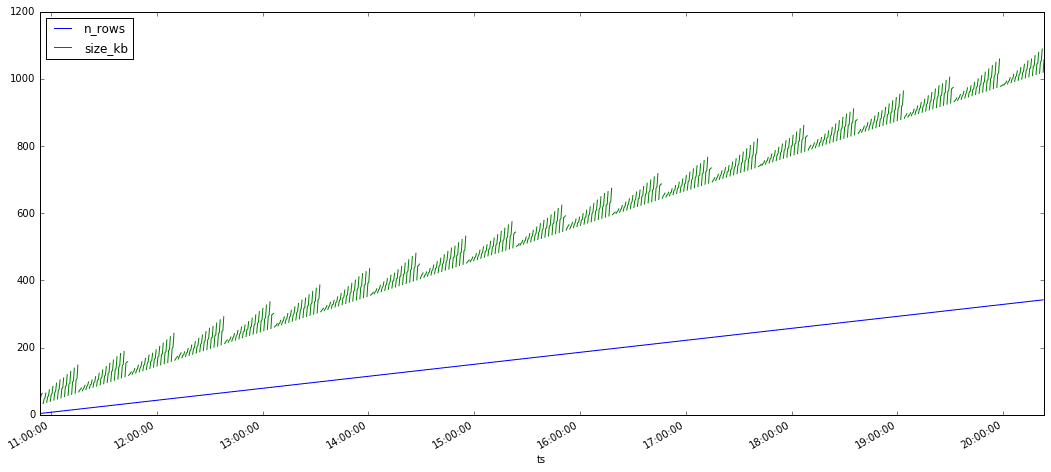

In [80]:
log['n_rows'] = log['msg'].str.extract('KB, (\d{1,10}) rows', expand=False).astype(float) / 100
log.loc[log['n_rows'].isnull(), 'n_rows'] = log.loc[log['n_rows'].isnull(), 'msg'].str.extract('ROWS_NOW=(\d{1,10})', expand=False).astype(float) / 100
log['size_kb'] = log['msg'].str.extract('Size Store: (\d{1,10}\.\d) KB,', expand=False).astype(float)
log.loc[log['size_kb'].isnull(), 'size_kb'] = log.loc[log['size_kb'].isnull(), 'msg'].str.extract('New Size: (\d{1,10}\.\d) KB', expand=False).astype(float)
#log['size_kb_c'] = log['msg'].str.extract('New Size: (\d{1,10}\.\d) KB', expand=False).astype(float)

log.T.drop('exec').T.plot(figsize=(18, 8))

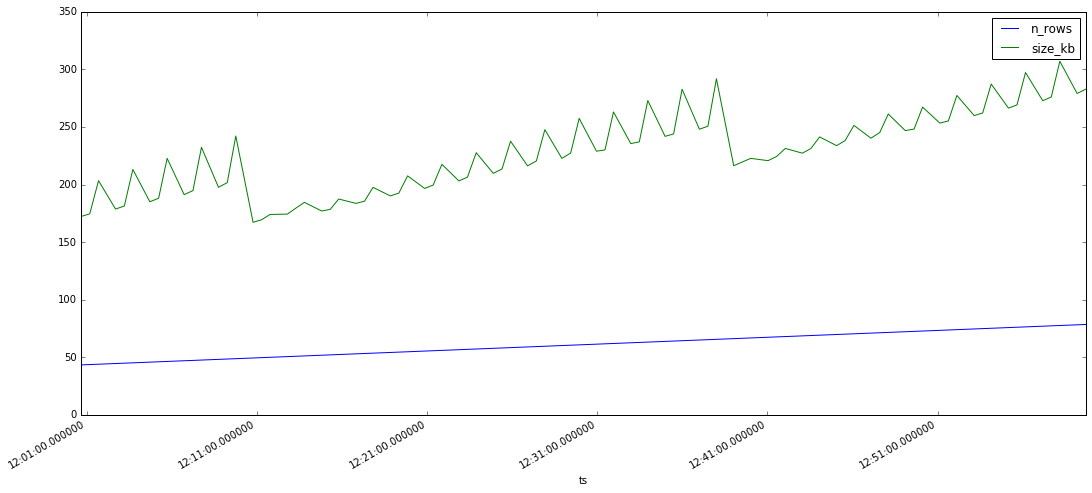

In [85]:
log.T.drop('exec').T.between_time('12:00', '13:00').dropna().plot(figsize=(18, 8))

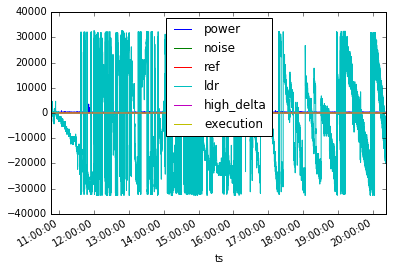

In [86]:
data.plot()

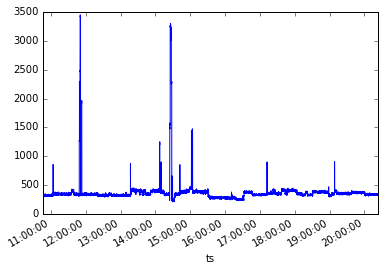

In [88]:
data.power.plot()

In [94]:
data.to_hdf('pruebas.hf5', 'data')
print_yellow(os.path.getsize('pruebas.hf5') / 1000)
with pd.HDFStore('pruebas.hf5', 'w') as st:
    print_infob(st)
    #print_infob(st.remove('/data'))
    print_magenta(os.path.getsize('pruebas.hf5') / 1000)

967.68
<class 'pandas.io.pytables.HDFStore'>
File path: pruebas.hf5
Empty
0.0


In [96]:
STORE_EXT = '.h5'
DIR_CURRENT_MONTH = 'CURRENT_MONTH'
DIR_BACKUP = 'OLD_STORES'
ST_TODAY = 'TODAY' + STORE_EXT
os.path.join(DIR_CURRENT_MONTH, ST_TODAY)

'CURRENT_MONTH/TODAY.h5'

In [135]:
pru = data.head()
pru2 = pru.copy()
#pru2.index = pru2.index + pd.Timedelta('2D')
print(pru)
pru2
pru3 = pd.DataFrame(pd.concat([pru, pru2], axis=0)).reset_index().drop_duplicates(subset='ts').set_index('ts')
pru3.index.is_monotonic_increasing

df = pd.DataFrame([], columns=['st', 'key', 'ts_ini', 'ts_fin', 'ts_st', 'n_rows', 'is_raw', 'cols']
            ).sort_values(by='ts_ini')
pru2.ref += 100
pru2
index = pd.read_csv('data_catalog.csv', index_col=0, parse_dates=['ts_ini', 'ts_fin', 'ts_st'])
index.cols = index.cols.map(lambda x: json.loads(x.replace("'", '"')))

index = index.drop_duplicates(subset=['st', 'key', 'ts_st', 'ts_ini', 'ts_fin'])
index.tail()

                                 power     noise  ref   ldr  high_delta  execution
ts                                                                                
2016-08-12 10:46:25.990460  321.977661  0.006370  182  5640         0.0        0.0
2016-08-12 10:46:27.001776  321.467957  0.006482  184  4640         0.0        0.0
2016-08-12 10:46:28.001279  312.116974  0.006540  183  3640         0.0        0.0
2016-08-12 10:46:29.003281  306.766022  0.006651  183  2640         0.0        0.0
2016-08-12 10:46:30.013803  310.393005  0.006622  184  1640         0.0        0.0


,cols,is_cat,is_raw,key,n_rows,st,ts_fin,ts_ini,ts_st
20,"[kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...",True,False,/hours,11,CURRENT_MONTH/DATA_2016_08_DAY_11.h5,2016-08-11 11:00:00.000000,2016-08-11 01:00:00.000000,2016-08-13 17:03:26
21,"[power, noise, ref, ldr, high_delta, execution]",True,True,/rms,360,CURRENT_MONTH/DATA_2016_08_DAY_11.h5,2016-08-11 11:27:40.109109,2016-08-11 01:26:02.433825,2016-08-13 17:03:26
0,"[kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...",True,False,/hours,9,CURRENT_MONTH/DATA_2016_08_DAY_13.h5,2016-08-13 23:00:00.000000,2016-08-13 15:00:00.000000,2016-08-14 00:02:24
1,"[power, noise, ref, ldr, high_delta, execution]",True,True,/rms,736,CURRENT_MONTH/DATA_2016_08_DAY_13.h5,2016-08-13 23:59:59.581018,2016-08-13 15:38:35.080073,2016-08-14 00:02:24
2,"[power, noise, ref, ldr, high_delta, execution]",False,True,/rms,844,CURRENT_MONTH/TODAY.h5,2016-08-14 00:02:23.916207,2016-08-13 15:38:35.080073,2016-08-14 00:02:24


In [143]:
pd.read_hdf('DATA_YEAR_2016/DATA_2016_MONTH_08.h5', 'hours')
#pd.read_hdf('debug_buffer_disk.h5', 'rms')

,kWh,t_ref,n_jump,n_exec,p_max,p_mean,p_min
ts,,,,,,,
2016-08-01 19:00:00,0.001968,0.033459,0,0,75.0,59.0,40.0
2016-08-01 20:00:00,1.769897,1.100953,1,1,2384.0,1605.0,1429.0
2016-08-01 21:00:00,0.715201,1.000046,0,0,1635.0,715.0,231.0
2016-08-01 22:00:00,1.716943,1.000071,0,0,6568.0,1717.0,401.0
2016-08-01 23:00:00,0.515473,1.000022,0,0,606.0,515.0,474.0
2016-08-02 00:00:00,0.412913,1.000114,0,0,1284.0,413.0,268.0
2016-08-02 01:00:00,0.385426,0.999798,0,0,459.0,386.0,367.0
2016-08-02 02:00:00,0.376195,1.000069,0,0,394.0,376.0,363.0
2016-08-02 03:00:00,0.340966,0.999930,0,0,1157.0,341.0,259.0


In [34]:
#pd.read_hdf('TODAY.h5', 'rms')
import json
index = pd.read_csv('/Users/uge/Dropbox/PYTHON/PYPROJECTS/enerpi/enerpi/DATA/data_catalog.csv', 
                    index_col=0, parse_dates=['ts_ini', 'ts_fin'])
index.cols = index.cols.map(lambda x: json.loads(x.replace("'", '"')))
print_info(index.dtypes)
index

st                object
key               object
ts_ini    datetime64[ns]
ts_fin    datetime64[ns]
n_rows             int64
is_raw              bool
cols              object
is_cat              bool
dtype: object


,st,key,ts_ini,ts_fin,n_rows,is_raw,cols,is_cat
0,enerpi_data_one.h5,/raw,2016-07-29 21:05:58.806360,2016-07-30 00:27:08.066015,12030,False,"['c1', 'c2', 'c3', 'c4']",False
1,enerpi_data_two.h5,/raw,2016-07-30 11:26:52.956885,2016-07-30 15:34:46.980851,6780,False,"['c1', 'c2', 'c3', 'c4']",False
2,CURRENT_MONTH/DATA_2016_08_DAY_01.h5,/hours,2016-08-01 19:00:00.000000,2016-08-01 23:00:00.000000,5,False,"['kWh', 't_ref', 'n_jump', 'n_exec', 'p_max', ...",True
3,CURRENT_MONTH/DATA_2016_08_DAY_01.h5,/rms,2016-08-01 19:51:56.200602,2016-08-01 23:59:59.576685,13753,True,"['power', 'noise', 'ref', 'ldr', 'high_delta',...",True
4,CURRENT_MONTH/DATA_2016_08_DAY_02.h5,/hours,2016-08-02 00:00:00.000000,2016-08-02 23:00:00.000000,24,False,"['kWh', 't_ref', 'n_jump', 'n_exec', 'p_max', ...",True
5,CURRENT_MONTH/DATA_2016_08_DAY_02.h5,/rms,2016-08-02 00:00:00.582596,2016-08-02 23:59:59.400328,73566,True,"['power', 'noise', 'ref', 'ldr', 'high_delta',...",True
6,CURRENT_MONTH/DATA_2016_08_DAY_03.h5,/hours,2016-08-03 00:00:00.000000,2016-08-03 23:00:00.000000,24,False,"['kWh', 't_ref', 'n_jump', 'n_exec', 'p_max', ...",True
7,CURRENT_MONTH/DATA_2016_08_DAY_03.h5,/rms,2016-08-03 00:00:00.410995,2016-08-03 23:59:59.800320,80856,True,"['power', 'noise', 'ref', 'ldr', 'high_delta',...",True
8,CURRENT_MONTH/DATA_2016_08_DAY_04.h5,/hours,2016-08-04 00:00:00.000000,2016-08-04 23:00:00.000000,24,False,"['kWh', 't_ref', 'n_jump', 'n_exec', 'p_max', ...",True
9,CURRENT_MONTH/DATA_2016_08_DAY_04.h5,/rms,2016-08-04 00:00:00.803527,2016-08-04 23:59:59.397089,85690,True,"['power', 'noise', 'ref', 'ldr', 'high_delta',...",True


0                                      [c1, c2, c3, c4]
1                                      [c1, c2, c3, c4]
2     [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
3       [power, noise, ref, ldr, high_delta, execution]
4     [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
5       [power, noise, ref, ldr, high_delta, execution]
6     [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
7       [power, noise, ref, ldr, high_delta, execution]
8     [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
9       [power, noise, ref, ldr, high_delta, execution]
10    [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
11      [power, noise, ref, ldr, high_delta, execution]
12    [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
13      [power, noise, ref, ldr, high_delta, execution]
14    [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
15      [power, noise, ref, ldr, high_delta, execution]
16    [kWh, t_ref, n_jump, n_exec, p_max, p_mean, p_...
17      [power, noise, ref, ldr, high_delta, exe

In [49]:
json.loads(index.cols[22].replace("'", '"'))

['power', 'noise', 'ref', 'ldr', 'high_delta', 'execution']

In [144]:
#'enerpi.log'

log = extract_log_file('enerpi.log')
log

                msg  temp  debug_send  no_red  CPU  GPU
exec tipo                                              
0    INFO         1     0           0       0    0    0
1    DEBUG       13     0           0       0    0    0
     INFO         2     0           0       0    0    0
2    DEBUG     5076     0           0       0    0    0
     INFO         2     0           0       0    0    0
     WARNING  27938     0           0   27938    0    0
3    DEBUG        1     0           0       0    0    0
     INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
4    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
5    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
6    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
7    INFO         2     0           0       0   

,tipo,msg,temp,debug_send,no_red,exec,CPU,GPU
ts,,,,,,,,
2016-08-12 10:47:29,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,NaN,NaN,0,NaN,NaN
2016-08-12 10:47:29,INFO,Init ENERPI logging & broadcasting...,NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:48:00,DEBUG,"Size Store: 2e+01 KB, 60 rows",NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:48:30,DEBUG,"Size Store: 2e+01 KB, 90 rows",NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:49:01,DEBUG,"Size Store: 3e+01 KB, 120 rows",NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:49:31,DEBUG,Se procede a compactar Store. ROWS_ANT=120. RO...,NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:49:31,DEBUG,Compacted Store. New Size: 2e+01 KB,NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:50:01,DEBUG,"Size Store: 3e+01 KB, 180 rows",NaN,NaN,NaN,1,NaN,NaN
2016-08-12 10:50:31,DEBUG,"Size Store: 3e+01 KB, 210 rows",NaN,NaN,NaN,1,NaN,NaN


In [153]:
last_hours = 24
pd.Timestamp.now().replace(minute=0, second=0, microsecond=0) - pd.Timedelta(hours=last_hours)

Timestamp('2016-08-13 22:00:00')

In [152]:
pd.Timestamp.now().replace(minute=0, second=0, microsecond=0)

Timestamp('2016-08-14 22:00:00')

In [154]:
last_data = pd.read_hdf('OLD_STORES/debug.h5', 'rms')
last_data.info()
last_data.count()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80979 entries, 2016-08-14 00:00:00.002919 to 2016-08-14 22:42:06.793853
Data columns (total 6 columns):
power         80979 non-null float32
noise         80979 non-null float32
ref           80979 non-null int16
ldr           80979 non-null int16
high_delta    80979 non-null bool
execution     80979 non-null bool
dtypes: bool(2), float32(2), int16(2)
memory usage: 1.7 MB


power         80979
noise         80979
ref           80979
ldr           80979
high_delta    80979
execution     80979
dtype: int64

In [159]:
raw_data = pd.read_hdf('OLD_STORES/temp_data.h5', 'rms')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122200 entries, 2016-08-12 10:46:25.990460 to 2016-08-13 21:01:02.646345
Data columns (total 4 columns):
power    122200 non-null float64
noise    122200 non-null float64
ref      122200 non-null float64
ldr      122200 non-null float64
dtypes: float64(4)
memory usage: 4.7 MB


In [161]:
p_data = pd.concat([pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_12.h5', 'rms'), 
                    pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_13.h5', 'rms')]).loc[:'2016-08-13 21:01:02']
p_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122200 entries, 2016-08-12 10:46:25.990460 to 2016-08-13 21:01:02.646345
Data columns (total 6 columns):
power         122200 non-null float32
noise         122200 non-null float32
ref           122200 non-null int16
ldr           122200 non-null int16
high_delta    122200 non-null bool
execution     122200 non-null bool
dtypes: bool(2), float32(2), int16(2)
memory usage: 2.6 MB


In [166]:
(raw_data.ldr - p_data.ldr).describe()

count    122200.000000
mean      -2832.127295
std       17675.369619
min      -32711.443491
25%      -14999.984856
50%        -465.533508
75%        1608.194933
max       32752.426491
Name: ldr, dtype: float64

In [182]:
ldr = pd.concat([raw_data.ldr, p_data.ldr], axis=1)
ldr.columns = ['raw', 'process']
ldr['calc'] = (ldr.raw * 1000.).round(0).astype('int16')
compara = ldr[ldr.calc != ldr.process].groupby(['process', 'calc']).count()
d_ren = compara.reset_index().sort_values(by='calc').set_index('process')['calc'].to_dict()

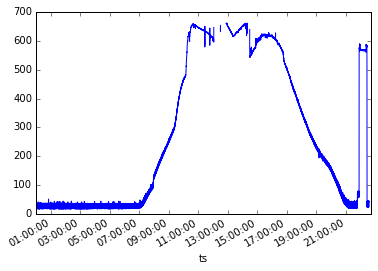

In [185]:
last_data.ldr.map(d_ren).plot()

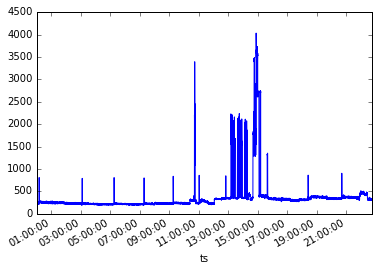

In [186]:
last_data.power.plot()

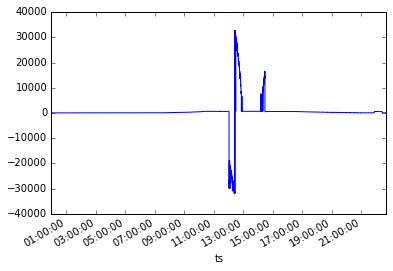

In [190]:
last_data.ldr.apply(lambda x: d_ren[x] if x in d_ren else x).plot()

In [191]:
raw_data_last = pd.read_hdf('enerpi_data.h5', 'rms')
raw_data_last.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2940 entries, 2016-08-15 00:35:11.165237 to 2016-08-15 01:24:36.739741
Data columns (total 4 columns):
power    2940 non-null float64
noise    2940 non-null float64
ref      2940 non-null float64
ldr      2940 non-null float64
dtypes: float64(4)
memory usage: 114.8 KB


In [193]:
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_12.h5', 'rms').info()
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_13.h5', 'rms').info()
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_14.h5', 'rms').info()
pd.read_hdf('CURRENT_MONTH/TODAY.h5', 'rms').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47122 entries, 2016-08-12 10:46:25.990460 to 2016-08-12 23:59:59.778947
Data columns (total 6 columns):
power         47122 non-null float32
noise         47122 non-null float32
ref           47122 non-null int16
ldr           47122 non-null int16
high_delta    47122 non-null bool
execution     47122 non-null bool
dtypes: bool(2), float32(2), int16(2)
memory usage: 1012.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81159 entries, 2016-08-13 00:00:00.784081 to 2016-08-13 23:59:58.992496
Data columns (total 6 columns):
power         81159 non-null float32
noise         81159 non-null float32
ref           81159 non-null int16
ldr           81159 non-null int16
high_delta    81159 non-null bool
execution     81159 non-null bool
dtypes: bool(2), float32(2), int16(2)
memory usage: 1.7 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85608 entries, 2016-08-14 00:00:00.002919 to 2016-08-14 23:59:59.474740
Data columns (to

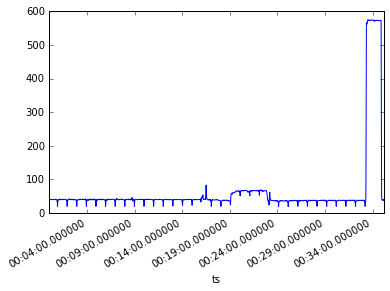

In [195]:
pd.read_hdf('CURRENT_MONTH/TODAY.h5', 'rms').ldr.map(d_ren).plot()

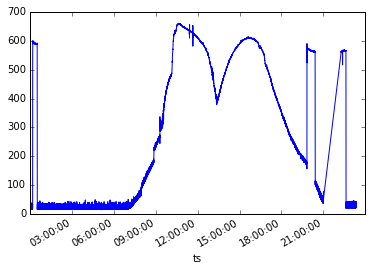

In [199]:
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_13.h5', 'rms').ldr.map(d_ren).plot()

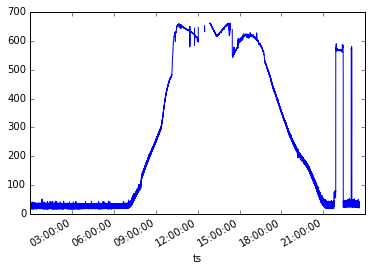

In [202]:
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_14.h5', 'rms').ldr.map(d_ren).plot()

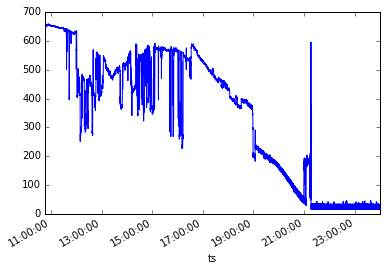

In [201]:
pd.read_hdf('CURRENT_MONTH/DATA_2016_08_DAY_12.h5', 'rms').ldr.plot()

In [215]:
import random
(pd.Series(np.linspace(0, 1, 1001)) * 1000).apply(lambda x: x + random.random() / 10).round(0).astype('int16')

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
11        11
12        12
13        13
14        14
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
28        28
29        29
        ... 
971      971
972      972
973      973
974      974
975      975
976      976
977      977
978      978
979      979
980      980
981      981
982      982
983      983
984      984
985      985
986      986
987      987
988      988
989      989
990      990
991      991
992      992
993      993
994      994
995      995
996      996
997      997
998      998
999      999
1000    1000
dtype: int16

In [221]:
log = extract_log_file('enerpi.log')
last_log = log[log['exec'] == log['exec'].max()].dropna(how='all', axis=1)
last_log.head()

                msg  temp  debug_send  no_red  CPU  GPU
exec tipo                                              
0    INFO         1     0           0       0    0    0
1    DEBUG       13     0           0       0    0    0
     INFO         2     0           0       0    0    0
2    DEBUG     5076     0           0       0    0    0
     INFO         2     0           0       0    0    0
     WARNING  27938     0           0   27938    0    0
3    DEBUG        1     0           0       0    0    0
     INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
4    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
5    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
6    INFO         2     0           0       0    0    0
     WARNING      1     0           0       1    0    0
7    INFO         2     0           0       0   

,tipo,msg,no_red,exec
ts,,,,
2016-08-13 22:20:43,INFO,Init ENERPI logging & broadcasting...,NaN,14
2016-08-13 22:21:44,DEBUG,"Size Store: 20.9 KB, 60 rows",NaN,14
2016-08-13 22:22:44,DEBUG,"Size Store: 24.3 KB, 120 rows",NaN,14
2016-08-13 22:23:45,DEBUG,"Size Store: 26.8 KB, 180 rows",NaN,14
2016-08-13 22:24:45,DEBUG,"Size Store: 33.2 KB, 240 rows",NaN,14


In [223]:
last_log[last_log.tipo == 'INFO']

,tipo,msg,no_red,exec
ts,,,,
2016-08-13 22:20:43,INFO,Init ENERPI logging & broadcasting...,NaN,14
2016-08-14 22:35:02,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,14
2016-08-14 22:37:22,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,14
2016-08-14 22:39:51,INFO,︎⚡⚡ ︎ENERPI AC CURRENT SENSOR ⚡⚡,NaN,14


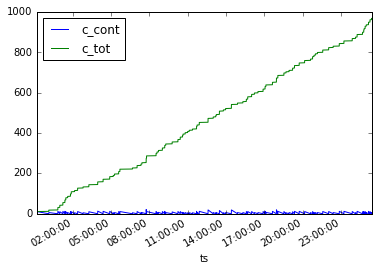

In [238]:
# Extract 'OSError: [Errno 101] La red es inaccesible; C_UNREACHABLE: [  6 969]'
c_unreach = last_log[last_log.msg.str.contains('Errno 101')
                    ].msg.str.extract('C_UNREACHABLE: \[\s?\s?\s?\s?\s?\s?\s?(?P<c_cont>\d{1,10}) (?P<c_tot>\d{1,10})\]', 
                                      expand=True).astype(int)
c_unreach.plot()

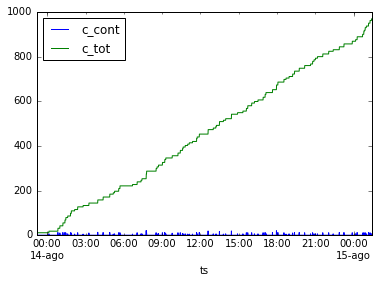

In [243]:
cu = c_unreach.resample('1s').first()
cu.c_cont = cu.c_cont.fillna(method='bfill').astype(int)
cu.c_tot = cu.c_tot.fillna(method='ffill').astype(int)
cu.plot()

In [244]:
cu.describe()

,c_cont,c_tot
count,94379.000000,94379.000000
mean,0.054747,454.080908
std,0.671815,276.893050
min,0.000000,0.000000
25%,0.000000,221.000000
50%,0.000000,453.000000
75%,0.000000,704.000000
max,21.000000,969.000000


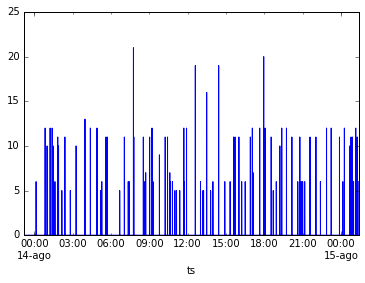

In [245]:
cu.c_cont.plot()

In [247]:
cu.resample('1h').max()

,c_cont,c_tot
ts,,
2016-08-13 23:00:00,11,11
2016-08-14 00:00:00,12,42
2016-08-14 01:00:00,12,109
2016-08-14 02:00:00,11,133
2016-08-14 03:00:00,13,158
2016-08-14 04:00:00,12,184
2016-08-14 05:00:00,11,221
2016-08-14 06:00:00,5,227
2016-08-14 07:00:00,21,287
